In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../terraforming-mars-stats.csv')
unique_sorted_game_ids = pd.Series([x for _,x in sorted(zip(df.date, df.game_id))]).unique() # for time-based stuff

# Summary

In [ ]:
df.groupby('player').\
agg(wins = ('is_winner','sum'), games = ('is_winner', 'count'), win_rate = ('is_winner','mean')).\
sort_values(by='win_rate', ascending=False)

# Individual Player Summary

In [ ]:
player = 'Tony'
player_df = df[df.player == player]

In [ ]:
# player history
player_df.groupby('player').\
agg(wins = ('is_winner','sum'), games = ('is_winner', 'count'), win_rate = ('is_winner','mean'))

In [ ]:
pd.to_datetime(player_df['date'])

In [ ]:
# most recent win
player_df[player_df['is_winner']==1].sort_values(by='date', ascending=False).head(1)

# Player ELO

In [107]:
# https://towardsdatascience.com/developing-a-generalized-elo-rating-system-for-multiplayer-games-b9b495e87802

# scoring functions
def linear_score(p, n):
    '''
    Args:
        p : int 
            Finishing place
        n : int 
            # of players
    '''
    return (n-p)/ (n*(n-1)/2)

def exp_score(p, n, alpha=2.):
    '''
    Args:
        p : int 
            Finishing place
        n : int 
            # of players
        alpha : exists in (1,inf)'''
    return (alpha**(n-p) - 1) / np.sum([(alpha**(n-i) - 1) for i in range(1,n)])

# expected score
def expected_score(s, player, n, d=400):
    '''
    Args:
        s : dict
            Players scores, ex.: {'Tony': 90, 'Pat': 80, ...}
        player : str
            Player of interest
        n : int 
            # of players
    '''
    return np.sum([(1/(1+10**((s[i] - s[player])/d))) if i != player else 0 for i in s.keys()])/(n*(n-1)/2)

def update_rating(current_rating, expected_score, actual_score, n, k=32):
    '''
    Args:
        current_rating : int
        expected_score : float
        actual_score : float
        n : int
            # of players
        k : int
    '''
    return current_rating + k*(n-1)*(actual_score-expected_score)

In [108]:
player_ratings = {player: {1: {'date':(min(pd.to_datetime(df.date)) - pd.Timedelta(days=1)),
                               'rating':1000}} for player in df.player.unique()}
current_ratings = {player: 1000 for player in df.player.unique()}
i = 2

for game_id in unique_sorted_game_ids:
    game_df = df[df['game_id'] == game_id]
    game_df['place'] = game_df['total_points'].rank(ascending=False)
    
    new_ratings = {}
    current_ratings_active_players = {player: rating for player, rating in current_ratings.items() if player in game_df.player.unique()}

    for player, place, date in zip(game_df.player, game_df.place, game_df.date):
        expected = expected_score(s=current_ratings_active_players, player=player, n=game_df.shape[0])
        observed = exp_score(p=place, n=game_df.shape[0])
        updated =  update_rating(current_rating=current_ratings_active_players[player], 
                                 expected_score=expected, 
                                 actual_score=observed, 
                                 n=game_df.shape[0])
        new_ratings[player] = {'previous': current_ratings_active_players[player],
                               'expected': expected,
                               'observed': observed,
                               'updated_rating': updated}

    for player in current_ratings.keys():
            if player in new_ratings.keys(): # player played in current game
                current_ratings[player] = new_ratings[player]['updated_rating']
                player_ratings[player][i] = {'date': pd.to_datetime(date), 'rating': new_ratings[player]['updated_rating']}
            else: # player did not play in current game
                player_ratings[player][i] = {'date': pd.to_datetime(date), 'rating': current_ratings[player]}
    
    i += 1
    
player_rating_dfs_list = [pd.DataFrame(player_ratings[player]).T.reset_index().assign(player=player)\
                          for player in player_ratings.keys()]
player_ratings_df = pd.concat(player_rating_dfs_list)
player_ratings_df.columns = ['game_number','date','rating','player']


/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


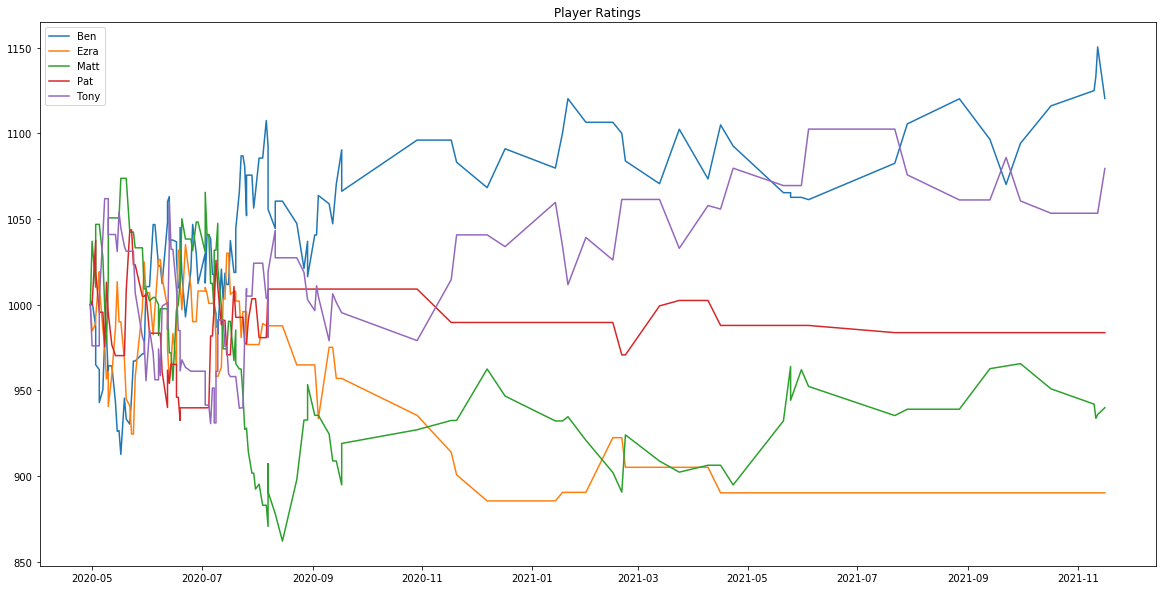

In [110]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

for player in ['Ben','Ezra','Matt','Pat','Tony']:#player_ratings_df.player.unique():
    player_rating_df = player_ratings_df[player_ratings_df['player']==player]
    ax.plot(player_rating_df.date, player_rating_df.rating, label=player)
ax.legend()
ax.set_title('Player Ratings');

# Corporation ELO

In [94]:
corp_ratings = {corp: {1: {'date':(min(pd.to_datetime(df.date)) - pd.Timedelta(days=1)),
                             'rating':1000}} for corp in df.corporation.unique()}
current_ratings = {corp: 1000 for corp in df.corporation.unique()}
i = 2

for game_id in unique_sorted_game_ids:
    game_df = df[df['game_id'] == game_id]
    game_df['place'] = game_df['total_points'].rank(ascending=False)
    
    new_ratings = {}
    current_ratings_active_corps = {corp: rating for corp, rating in current_ratings.items() if corp in game_df.corporation.unique()}

    for corp, place, date in zip(game_df.corporation, game_df.place, game_df.date):
        expected = expected_score(s=current_ratings_active_corps, player=corp, n=game_df.shape[0])
        observed = linear_score(p=place, n=game_df.shape[0])
        updated =  update_rating(current_rating=current_ratings_active_corps[corp], 
                                 expected_score=expected, 
                                 actual_score=observed, 
                                 n=game_df.shape[0])
        new_ratings[corp] = {'previous': current_ratings_active_corps[corp],
                               'expected': expected,
                               'observed': observed,
                               'updated_rating': updated}

    for corp in current_ratings.keys():
            if corp in new_ratings.keys(): # corp played in current game
                current_ratings[corp] = new_ratings[corp]['updated_rating']
                corp_ratings[corp][i] = {'date': pd.to_datetime(date), 'rating': new_ratings[corp]['updated_rating']}
            else: # corp did not play in current game
                corp_ratings[corp][i] = {'date': pd.to_datetime(date), 'rating': current_ratings[corp]}
    
    i += 1
    
corp_rating_dfs_list = [pd.DataFrame(corp_ratings[corp]).T.reset_index().assign(corporation=corp)\
                          for corp in corp_ratings.keys()]
corp_ratings_df = pd.concat(corp_rating_dfs_list)
corp_ratings_df.columns = ['game_number','date','rating','corporation']


/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


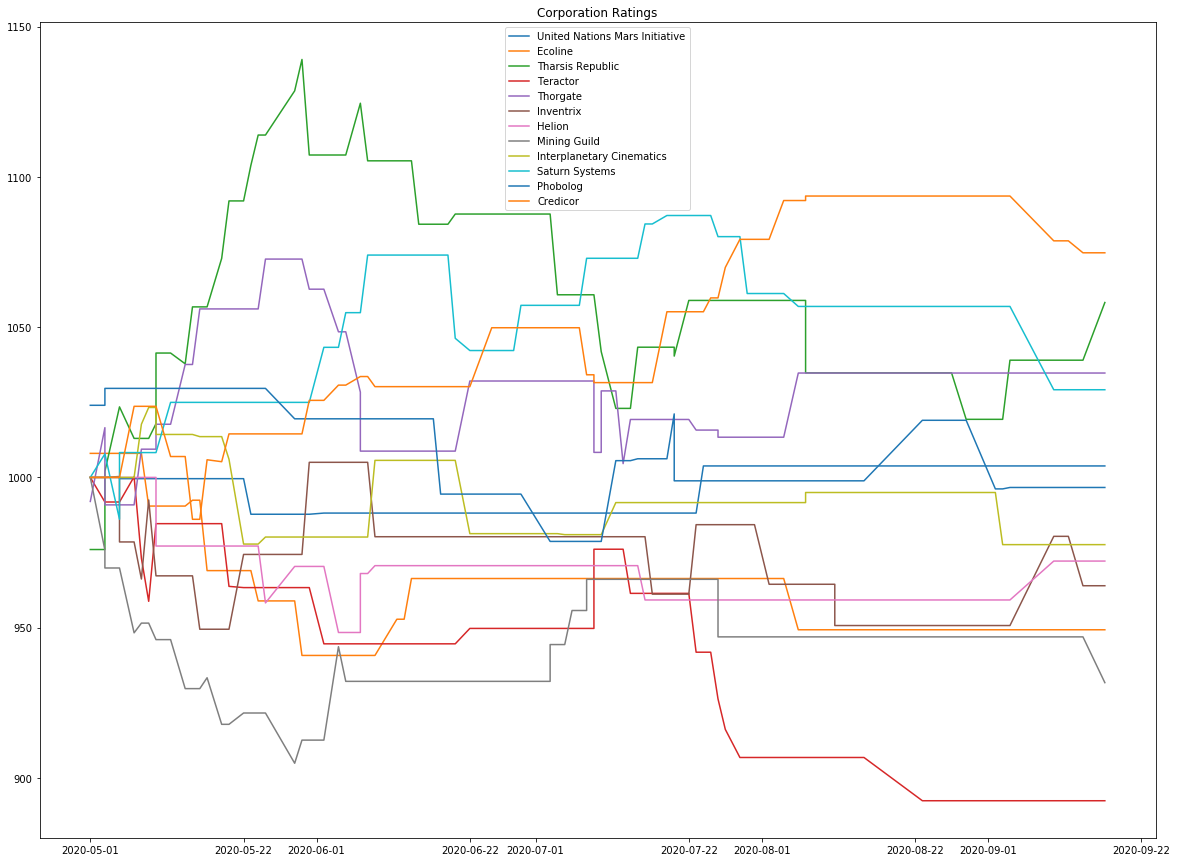

In [103]:
fig, ax = plt.subplots(1,1, figsize=(20,15))

for corp in set(df[df.corporation_origin=='Base'].corporation.unique()) - set(['Beginner']):
    corp_rating_df = corp_ratings_df[corp_ratings_df['corporation']==corp][1:100]
    ax.plot(corp_rating_df.date, corp_rating_df.rating, label=corp)
ax.legend()
ax.set_title('Corporation Ratings');